# Visium dataset (mouse brain)

We analyzed the mouse brain Visium dataset. This data can be obtained from 10x Genomics Data Repository (https://www.10xgenomics.com/datasets/mouse-brain-section-coronal-1-standard-1-1-0).

## 1. Import packages

In [1]:
import DiffGSP as dg
import torch
import scanpy as sc
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Arial']

/home/sunshuli/anaconda3/envs/DiffGSP_test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Read data

In [2]:
data_name = '1.1.0_V1_Adult_Mouse_Brain'
adata = sc.read_visium('/storage/sunshuli/datasets/Visium/' + data_name,
                       count_file=data_name + '_raw_feature_bc_matrix.h5')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 4992 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## 3. Data processing, including filtering genes and identifying svgs

In [3]:
mito_genes = adata.var_names.str.startswith('mt-')
adata = adata[:, ~mito_genes]
adata = adata[:, dg.prefilter_genes(adata, min_cells=3)]
svgs = dg.select_svgs(adata, svg_method='gft_top', n_top=2000)
adata = adata[:, svgs]
adata_raw = adata.copy()
adata

View of AnnData object with n_obs × n_vars = 4992 × 2000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## 4. Run DiffGSP

In [4]:
adata, optimal_solution, loss_list, constant = dg.run_diffgsp(adata, k=2, alpha=0, device=device, method='BFGS', max_iter=20, data_type='Visium')
optimal_solution

Training:  13%|█▋           | 13/100 [00:38<04:16,  2.95s/it, Loss=tensor(21.0749, device='cuda:0')]


tensor([0.2811, 0.1664], device='cuda:0', dtype=torch.float64)

## 5. Downstream analysis

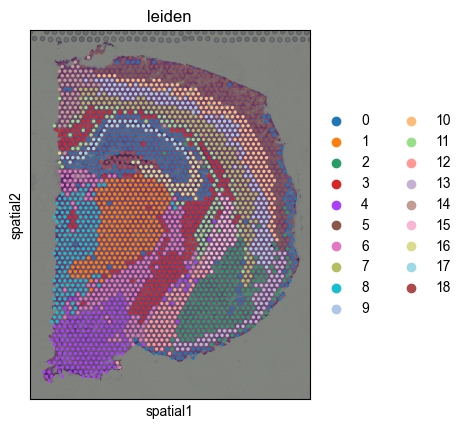

In [5]:
adata = adata[adata.obs['in_tissue'] == 1, :]
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.9)
sc.pl.spatial(adata, color='leiden')

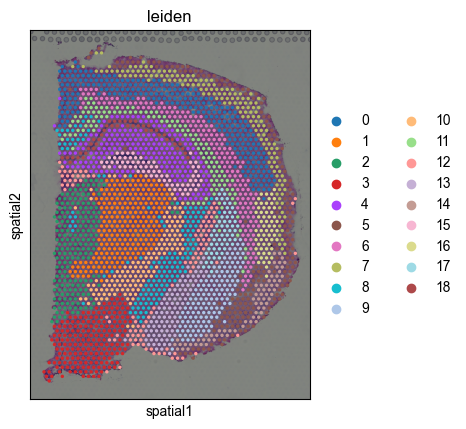

In [6]:
adata_raw = adata_raw[adata_raw.obs['in_tissue'] == 1, :]
sc.pp.normalize_total(adata_raw)
sc.pp.log1p(adata_raw)
sc.tl.pca(adata_raw)
sc.pp.neighbors(adata_raw)
sc.tl.leiden(adata_raw, resolution=1.0)
sc.pl.spatial(adata_raw, color='leiden')

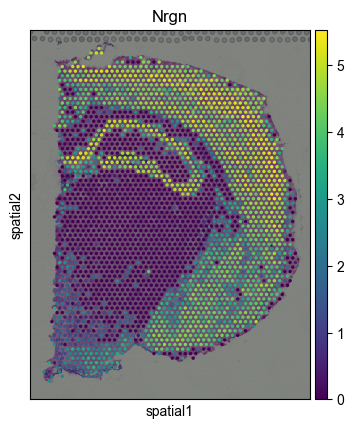

In [7]:
sc.pl.spatial(adata, color='Nrgn')

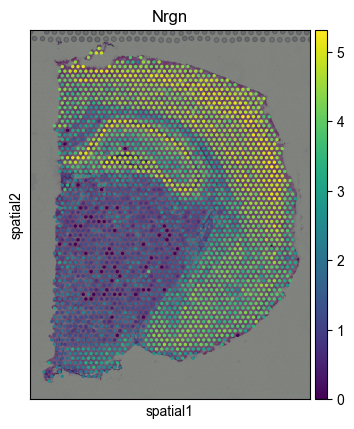

In [8]:
sc.pl.spatial(adata_raw, color='Nrgn')